In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from math import sqrt

# Latexify function with fallback fonts
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting."""
    assert(columns in [1,2])
    
    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9  # width in inches
    
    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0
        fig_height = fig_width*golden_mean
    
    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        fig_height = MAX_HEIGHT_INCHES
    
    params = {
        'axes.labelsize': 10,
        'axes.titlesize': 10,
        'font.size': 10,
        'legend.fontsize': 9,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'figure.figsize': [fig_width, fig_height],
        'font.family': 'sans-serif',
        'font.sans-serif': ['DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif'],
        'lines.linewidth': 1,
        'axes.linewidth': 1,
        'patch.linewidth': 0.8,
        'xtick.major.width': 1,
        'ytick.major.width': 1,
        'xtick.major.size': 4,
        'ytick.major.size': 4,
    }
    
    matplotlib.rcParams.update(params)

In [3]:
gt_df = pd.read_csv("/home/diya.thakor/AirQuality/Dataset/Ground_Truth_2023_Final.csv")

gt_df['year'] = pd.to_datetime(gt_df['YearMonth']).dt.year
gt_df['month'] = pd.to_datetime(gt_df['YearMonth']).dt.month_name()
print(gt_df.columns)
gt_df = gt_df[['city', 'state', 'year', 'month', 'PM2.5','latitude','longitude']].rename(columns={'PM2.5': 'ground_truth_pm25'})

gt_df

Index(['city', 'state', 'YearMonth', 'AT', 'BP', 'PM2.5', 'RF', 'VWS', 'WD',
       'WS', 'latitude', 'longitude', 'year', 'month'],
      dtype='object')


,city,state,year,month,ground_truth_pm25,latitude,longitude
0,Agartala,Tripura,2023,January,196.040103,23.817550,91.272697
1,Agartala,Tripura,2023,February,170.874875,23.817550,91.272697
2,Agartala,Tripura,2023,March,119.490881,23.817550,91.272697
3,Agartala,Tripura,2023,April,94.205356,23.817550,91.272697
4,Agartala,Tripura,2023,May,63.553585,23.817550,91.272697
...,...,...,...,...,...,...,...
2407,Yamuna Nagar,Haryana,2023,August,45.099735,30.148057,77.289347
2408,Yamuna Nagar,Haryana,2023,September,52.957552,30.148057,77.289347
2409,Yamuna Nagar,Haryana,2023,October,72.193644,30.148057,77.289347
2410,Yamuna Nagar,Haryana,2023,November,88.361732,30.148057,77.289347


In [4]:
gemma_9b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/gemma2_9b_it_2023_predictions.csv")
gemma_27b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/gemma2_27b_it_2023_predictions.csv")
# llama_8b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/llama3_8b_it_2023_predictions.csv")
llama_70b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/llama3_70b_it_2023_predictions.csv")
qwen_14b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/qwen3_14b_2023_predictions.csv")
qwen_32b_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/qwen3_32b_2023_predictions.csv")
gemini_flash_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/gemini_flash_2023.csv")
gpt_4o_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/gpt_4o_pm25.csv")
claude_sonnet_df = pd.read_csv("/home/diya.thakor/AirQuality/RQ1/Dataset/Predictions/claude_sonnet_2023.csv")

In [4]:
gemma_27b_df.head()

,city,state,year,month,model,pm2.5
0,Agartala,Tripura,2023,January,google/gemma-2-27b-it,78.0
1,Agartala,Tripura,2023,February,google/gemma-2-27b-it,72.0
2,Agartala,Tripura,2023,March,google/gemma-2-27b-it,58.0
3,Agartala,Tripura,2023,April,google/gemma-2-27b-it,52.0
4,Agartala,Tripura,2023,May,google/gemma-2-27b-it,52.0


In [5]:
gt_df['state'].unique()

array(['Tripura', 'Uttar Pradesh', 'Gujarat', 'Mizoram', 'Rajasthan',
       'Andhra Pradesh', 'Haryana', 'Punjab', 'Bihar', 'Tamil Nadu',
       'West Bengal', 'Maharashtra', 'Himachal Pradesh', 'Karnataka',
       'Odisha', 'Chhattisgarh', 'Madhya Pradesh', 'Assam', 'Chandigarh',
       'Uttarakhand', 'Delhi', 'Kerala', 'Sikkim', 'Telangana',
       'Nagaland', 'Arunachal Pradesh', 'Puducherry', 'Meghalaya',
       'Jammu and Kashmir'], dtype=object)

In [6]:
gt_df['state'].nunique()

29

In [5]:
# Part 1: Define mapping, helper, models, selected/ordering, and compute regional_metrics_df

# 1) Region mapping and helper
region_mapping = {
    'north': ['uttar pradesh', 'haryana', 'punjab', 'himachal pradesh',
              'uttarakhand', 'jammu and kashmir', 'chandigarh', 'delhi'],
    'south': ['tamil nadu', 'karnataka', 'andhra pradesh', 'telangana',
              'kerala', 'puducherry'],
    'east': ['west bengal', 'bihar', 'odisha'],
    'west': ['maharashtra', 'gujarat', 'rajasthan'],
    'central': ['madhya pradesh', 'chhattisgarh'],
    'northeast': ['tripura', 'mizoram', 'assam', 'sikkim', 'nagaland',
                  'arunachal pradesh', 'meghalaya']
}

def get_region(state):
    state = str(state).lower().strip()
    for region, states in region_mapping.items():
        if state in states:
            return region
    return 'other'

# 2) Add region to gt_df (gt_df must have 'state' column)
gt_df['region'] = gt_df['state'].apply(get_region)

# 3) Quick check of city distribution
print("=== Cities per Region (lowercase keys) ===")
region_city_counts = gt_df.groupby('region')['city'].nunique()
print(region_city_counts)
print(f"Total cities: {gt_df['city'].nunique()}\n")

# 4) Prepare model_dfs dictionary (ensure these variables exist in your env)
model_dfs = {
    "gemma2-9b-it": gemma_9b_df,
    "gemma2-27b-it": gemma_27b_df,
    # "llama-3.1-8b-Instruct": llama_8b_df,
    "llama3.3-70b-Instruct": llama_70b_df,
    "qwen3-14b": qwen_14b_df,
    "qwen3-32b": qwen_32b_df,
    "gemini-2.5-flash": gemini_flash_df,
    "gpt-4o": gpt_4o_df,
    "claude-sonnet-4.5": claude_sonnet_df
}

# 5) Models to plot and desired region order (capitalized for display)
selected_models = [
    'gemma2-27b-it',
    'qwen3-32b',
    'llama3.3-70b-Instruct',
    'gemini-2.5-flash',
    'gpt-4o',
    'claude-sonnet-4.5'
]

# region_order used later in plotting (capitalized form)
region_order = ['South', 'West', 'Northeast', 'Central', 'East', 'North']

=== Cities per Region (lowercase keys) ===
region
central      22
east         38
north        57
northeast    11
south        48
west         25
Name: city, dtype: int64
Total cities: 200



In [6]:
import numpy as np

def bootstrap_ci(metric_fn, y_true, y_pred, n_bootstrap=1000, alpha=0.05, random_state=0):
    """
    Generic non-parametric bootstrap CI for a scalar metric.
    metric_fn: function(y_true, y_pred) -> float
    Returns (lower, upper, std_boot).
    """
    rng = np.random.default_rng(random_state)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    n = len(y_true)

    stats = []
    for _ in range(n_bootstrap):
        idx = rng.integers(0, n, size=n)
        stats.append(metric_fn(y_true[idx], y_pred[idx]))
    stats = np.array(stats)

    lower = np.percentile(stats, 100 * alpha / 2)
    upper = np.percentile(stats, 100 * (1 - alpha / 2))
    return lower, upper, stats.std(ddof=1)

In [7]:
import numpy as np

def compute_metrics(
    df,
    n_bootstrap=1000,
    alpha=0.05,
    random_state=0,
):
    df = df.dropna(subset=["ground_truth_pm25", "pm2.5"])

    if df.empty:
        return {
            "MAE": np.nan,
            "Over %": np.nan,
            "Under %": np.nan,
            "MAEunder": np.nan,
            "MAEover": np.nan,
            "Samples": 0,
            # uncertainty
            "MAE_se": np.nan,
            "MAE_ci_low_param": np.nan,
            "MAE_ci_high_param": np.nan,
            "MAE_ci_low_boot": np.nan,
            "MAE_ci_high_boot": np.nan,
            "MAE_std_boot": np.nan,
        }

    gt = df["ground_truth_pm25"].to_numpy()
    pred = df["pm2.5"].to_numpy()
    n = len(df)

    abs_error = np.abs(gt - pred)
    mae = abs_error.mean()

    # -------- directional errors --------
    under_mask = pred < gt
    over_mask = pred > gt

    mae_under = abs_error[under_mask].mean() if under_mask.any() else np.nan
    mae_over  = abs_error[over_mask].mean()  if over_mask.any() else np.nan

    under_pct = 100 * under_mask.sum() / n
    over_pct  = 100 * over_mask.sum()  / n

    # ===================================
    # Uncertainty estimates for MAE
    # ===================================
    if n > 1:
        # 1) SE (MAE is mean of |error|)
        mae_se = abs_error.std(ddof=1) / np.sqrt(n)

        # 2) Parametric CI
        z = 1.96
        mae_ci_low_param = mae - z * mae_se
        mae_ci_high_param = mae + z * mae_se

        # 3) Bootstrap CI
        if n_bootstrap and n > 5:
            from numpy.random import default_rng
            rng = default_rng(random_state)

            stats = []
            for _ in range(n_bootstrap):
                idx = rng.integers(0, n, size=n)
                stats.append(np.mean(np.abs(gt[idx] - pred[idx])))
            stats = np.array(stats)

            mae_ci_low_boot = np.percentile(stats, 100 * alpha / 2)
            mae_ci_high_boot = np.percentile(stats, 100 * (1 - alpha / 2))
            mae_std_boot = stats.std(ddof=1)
        else:
            mae_ci_low_boot = mae_ci_high_boot = mae_std_boot = np.nan
    else:
        mae_se = mae_ci_low_param = mae_ci_high_param = np.nan
        mae_ci_low_boot = mae_ci_high_boot = mae_std_boot = np.nan

    return {
        "MAE": round(mae, 4),
        "Over %": round(over_pct, 4),
        "Under %": round(under_pct, 4),
        "MAEunder": round(mae_under, 4) if not np.isnan(mae_under) else np.nan,
        "MAEover": round(mae_over, 4) if not np.isnan(mae_over) else np.nan,
        "Samples": n,

        # uncertainty outputs (for bar plots)
        "MAE_se": mae_se,
        "MAE_ci_low_param": mae_ci_low_param,
        "MAE_ci_high_param": mae_ci_high_param,
        "MAE_ci_low_boot": mae_ci_low_boot,
        "MAE_ci_high_boot": mae_ci_high_boot,
        "MAE_std_boot": mae_std_boot,
    }

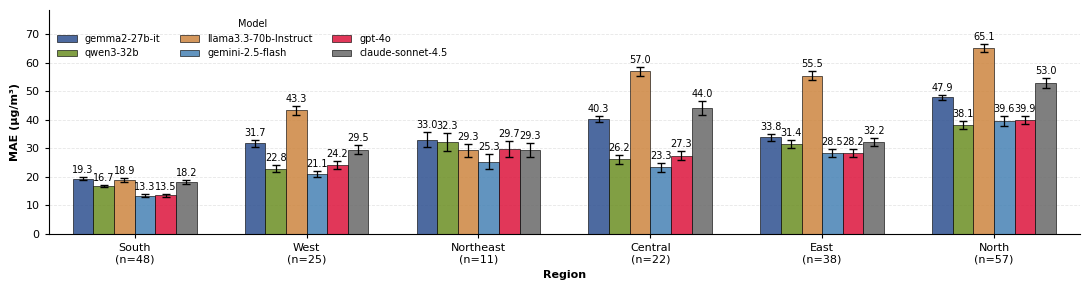

In [9]:
# Part 2: Build long-form regional_raw_df (one sample per merged row),
# compute MAE mean + SE per Region x Model, then plot grouped bars with error bars.

# 1) Build regional_raw_df using model_dfs and gt_df (one row per city or city-month sample)
rows = []
for model_name, model_df in model_dfs.items():
    merged = pd.merge(model_df, gt_df, on=["city", "state", "year", "month"], how="inner")
    if merged.empty:
        continue

    # Ensure 'region' exists (lowercase)
    if 'region' not in merged.columns:
        merged['region'] = merged['state'].apply(get_region)

    # compute absolute error per sample
    merged['abs_error'] = (merged['pm2.5'] - merged['ground_truth_pm25']).abs()

    # normalize Model/Region column names for aggregation
    merged['Model'] = model_name
    merged['Region'] = merged['region'].str.capitalize()

    rows.append(merged[['Model', 'Region', 'abs_error', 'city']])

if len(rows) == 0:
    raise ValueError("No merged rows found — check model_dfs and gt_df merges.")
regional_raw_df = pd.concat(rows, ignore_index=True)

# 2) Aggregate to get mean, std, count, and SE per (Region, Model)
agg_df = regional_raw_df.groupby(['Region', 'Model'])['abs_error'].agg(
    MAE_mean='mean',
    MAE_std='std',
    count='count'
).reset_index()

def compute_se(row):
    # If only 1 sample or std is NaN -> treat SE as 0.0 (you can change to np.nan if preferred)
    if row['count'] <= 1 or pd.isna(row['MAE_std']):
        return 0.0
    return row['MAE_std'] / np.sqrt(row['count'])

agg_df['MAE_se'] = agg_df.apply(compute_se, axis=1)

# 3) Pivot to wide form for plotting
pivot_mean = agg_df.pivot(index='Region', columns='Model', values='MAE_mean')
pivot_se   = agg_df.pivot(index='Region', columns='Model', values='MAE_se')

# Reindex to enforce plotting order (region_order defined in Part 1; selected_models too)
pivot_mean = pivot_mean.reindex(index=region_order)     # region_order has capitalized names
pivot_mean = pivot_mean.reindex(columns=selected_models)
pivot_se   = pivot_se.reindex(index=region_order)
pivot_se   = pivot_se.reindex(columns=selected_models)

# 4) Build region_cities mapping for labels (capitalized keys)
region_cities = gt_df.groupby('region')['city'].nunique().to_dict()
region_cities = {k.capitalize(): v for k, v in region_cities.items()}

# 5) Plot grouped bars with SE error bars and place numeric labels above error bars
latexify(columns=2, fig_height=3)
fig, ax = plt.subplots(1, 1, figsize=(11, 3))

colors = ['#2E5090', '#6B8E23', '#CD853F', '#4682B4', '#DC143C', '#696969']
n_regions = len(region_order)
n_models = len(selected_models)
bar_width = 0.12
x = np.arange(n_regions)

for i, (model, color) in enumerate(zip(selected_models, colors)):
    offset = (i - n_models/2 + 0.5) * bar_width
    mae_values = pivot_mean[model].values
    se_values  = pivot_se[model].values

    # mask invalid entries (NaN mean)
    valid_mask = ~np.isnan(mae_values)

    bars = ax.bar(
        x[valid_mask] + offset,
        mae_values[valid_mask],
        bar_width,
        label=model,
        color=color,
        alpha=0.85,
        edgecolor='black',
        linewidth=0.5,
        yerr=se_values[valid_mask],
        capsize=3,
        error_kw={'elinewidth': 0.9, 'capsize': 3}
    )

    # numeric labels above the error bar
    valid_indices = np.where(valid_mask)[0]
    for j, bar in enumerate(bars):
        idx = valid_indices[j]
        h = bar.get_height()
        se_val = se_values[idx] if (not np.isnan(se_values[idx])) else 0.0
        y_text = h + se_val + 0.7  # tweak offset if needed
        ax.text(
            bar.get_x() + bar.get_width() / 2.,
            y_text,
            f'{h:.1f}',
            ha='center', va='bottom',
            fontsize=7
        )

# Labels, ticks, and limits
ax.set_ylabel('MAE (µg/m³)', fontsize=8, fontweight='bold')
ax.set_xlabel('Region', fontsize=8, fontweight='bold')

region_labels = [f"{r}\n(n={region_cities.get(r, 0)})" for r in region_order]
ax.set_xticks(x)
ax.set_xticklabels(region_labels, fontsize=7)
ax.set_xlim(-0.5, n_regions - 0.5)

# y limit: slightly above max(mean + se)
max_mean_plus_se = np.nanmax((pivot_mean + pivot_se).values)
if np.isfinite(max_mean_plus_se):
    ax.set_ylim(0, float(max_mean_plus_se) * 1.18)

ax.legend(
    fontsize=7, title='Model',
    title_fontsize=7, ncol=3,
    loc='upper left', frameon=False
)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.8)
ax.spines['bottom'].set_linewidth(0.8)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.6)
ax.set_axisbelow(True)
ax.tick_params(labelsize=8, width=0.8, length=3)

plt.tight_layout()
plt.savefig('figure6.pdf', dpi=300, bbox_inches='tight', format='pdf')
plt.show()

In [10]:
import numpy as np
import pandas as pd

def build_region_metrics(
    model_dfs,
    gt_df,
    get_region,             # function: state -> region string
    n_bootstrap=1000,
    alpha=0.05,
    random_state=0,
):
    """
    Build a metrics dataframe with one row per (Region, Model),
    using your compute_metrics function.

    model_dfs: dict[model_name -> model_df]
    gt_df:     ground-truth dataframe
    get_region: function that maps state -> region
    """

    rows = []

    for model_name, model_df in model_dfs.items():
        merged = pd.merge(
            model_df,
            gt_df,
            on=["city", "state", "year", "month"],
            how="inner"
        )
        if merged.empty:
            continue

        # Ensure 'region' exists
        if "region" not in merged.columns:
            merged["region"] = merged["state"].apply(get_region)

        # Normalize model/region columns
        merged["Model"] = model_name
        merged["Region"] = merged["region"].str.capitalize()

        # compute metrics per Region for this model
        for region_name, g in merged.groupby("Region"):
            m = compute_metrics(
                g,
                n_bootstrap=n_bootstrap,
                alpha=alpha,
                random_state=random_state,
            )
            m["Model"] = model_name
            m["Region"] = region_name
            rows.append(m)

    region_metrics_df = pd.DataFrame(rows)

    # Get region-wise city counts from gt_df
    gt_tmp = gt_df.copy()
    if "region" not in gt_tmp.columns:
        gt_tmp["region"] = gt_tmp["state"].apply(get_region)
    gt_tmp["Region"] = gt_tmp["region"].str.capitalize()
    region_cities = gt_tmp.groupby("Region")["city"].nunique().to_dict()

    return region_metrics_df, region_cities

In [11]:
region_metrics_df, region_cities = build_region_metrics(
    model_dfs,
    gt_df,
    get_region,
    n_bootstrap=1000,
    alpha=0.05,
    random_state=0,
)


In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_region_mae_uncertainty(
    region_metrics_df,
    region_cities,
    region_order,
    selected_models,
    err_type="se",      # "se", "param_ci", "boot_ci"
    save_path=None,
):
    """
    Grouped bar plot:
      x-axis: Region (in region_order)
      bars:   Models in selected_models
      error bars: chosen uncertainty type.
    """

    df = region_metrics_df.copy()

    # restrict to selected models
    df = df[df["Model"].isin(selected_models)]

    # enforce region order and model order
    df["Region"] = pd.Categorical(df["Region"], categories=region_order, ordered=True)
    df["Model"] = pd.Categorical(df["Model"], categories=selected_models, ordered=True)
    df = df.sort_values(["Region", "Model"])

    n_regions = len(region_order)
    n_models = len(selected_models)

    x = np.arange(n_regions)

    # colors per model
    base_colors = ["#2E5090", "#6B8E23", "#CD853F", "#4682B4", "#DC143C", "#696969"]
    color_map = {
        model: base_colors[i % len(base_colors)]
        for i, model in enumerate(selected_models)
    }

    bar_width = 0.8 / n_models

    # choose y_max based on uncertainty type
    if err_type == "se":
        df["upper"] = df["MAE"] + df["MAE_se"]
    elif err_type == "param_ci":
        df["upper"] = df["MAE_ci_high_param"]
    elif err_type == "boot_ci":
        df["upper"] = df["MAE_ci_high_boot"]
    else:
        raise ValueError("err_type must be 'se', 'param_ci', or 'boot_ci'")

    y_max = np.nanmax(df["upper"].values)
    y_offset_label = y_max * 0.03

    fig, ax = plt.subplots(1, 1)

    for i, model in enumerate(selected_models):
        offset = (i - n_models / 2 + 0.5) * bar_width

        sub = df[df["Model"] == model].copy()
        sub = sub.set_index("Region").loc[region_order]  # ensure region order

        mae_vals = sub["MAE"].to_numpy()
        # select the right error bars
        if err_type == "se":
            err = sub["MAE_se"].to_numpy()
            err_low = err_high = err
        elif err_type == "param_ci":
            low = sub["MAE_ci_low_param"].to_numpy()
            high = sub["MAE_ci_high_param"].to_numpy()
            err_low = sub["MAE"].to_numpy() - low
            err_high = high - sub["MAE"].to_numpy()
        else:  # boot_ci
            low = sub["MAE_ci_low_boot"].to_numpy()
            high = sub["MAE_ci_high_boot"].to_numpy()
            err_low = sub["MAE"].to_numpy() - low
            err_high = high - sub["MAE"].to_numpy()

        valid_mask = ~np.isnan(mae_vals)
        xpos = x[valid_mask] + offset

        bars = ax.bar(
            xpos,
            mae_vals[valid_mask],
            bar_width,
            label=model if i == 0 else None,  # we'll override legend later
            color=color_map[model],
            alpha=0.85,
            edgecolor="black",
            linewidth=0.5,
            zorder=3,
        )

        # error bars
        ax.errorbar(
            xpos,
            mae_vals[valid_mask],
            yerr=np.vstack([err_low[valid_mask], err_high[valid_mask]]),
            fmt="none",
            capsize=3,
            color="black",
            linewidth=0.9,
            zorder=5,
        )

        # numeric labels above error bar
        valid_indices = np.where(valid_mask)[0]
        for j, bar in enumerate(bars):
            idx = valid_indices[j]
            h = mae_vals[idx]
            eh = err_high[idx]
            y_text = h + eh + y_offset_label
            ax.text(
                bar.get_x() + bar.get_width() / 2.0,
                y_text,
                f"{h:.1f}",
                ha="center",
                va="bottom",
                fontsize=7,
            )

    # x labels with city counts
    region_labels = [f"{r}\n(n={region_cities.get(r, 0)})" for r in region_order]
    ax.set_xticks(x)
    ax.set_xticklabels(region_labels, fontsize=7)

    ax.set_xlabel("Region", fontsize=8, fontweight="bold")
    ax.set_ylabel("MAE (µg/m³)", fontsize=8, fontweight="bold")

    ax.set_xlim(-0.5, n_regions - 0.5)

    if np.isfinite(y_max):
        ax.set_ylim(0, float(y_max) * 1.18)

    # legend: models
    handles = []
    labels = []
    for model in selected_models:
        handles.append(plt.Line2D([], [], color=color_map[model], marker="s", linestyle=""))
        labels.append(model)
    ax.legend(
        handles,
        labels,
        fontsize=7,
        title="Model",
        title_fontsize=7,
        ncol=3,
        loc="upper left",
        frameon=False,
    )

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(0.8)
    ax.spines["bottom"].set_linewidth(0.8)
    ax.grid(axis="y", alpha=0.3, linestyle="--", linewidth=0.6)
    ax.set_axisbelow(True)
    ax.tick_params(labelsize=8, width=0.8, length=3)

    fig.tight_layout()

    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches="tight", format="pdf")

    plt.show()

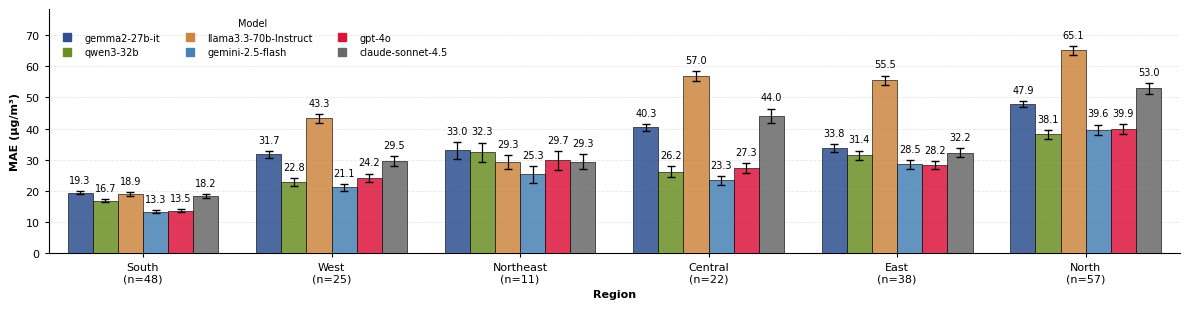

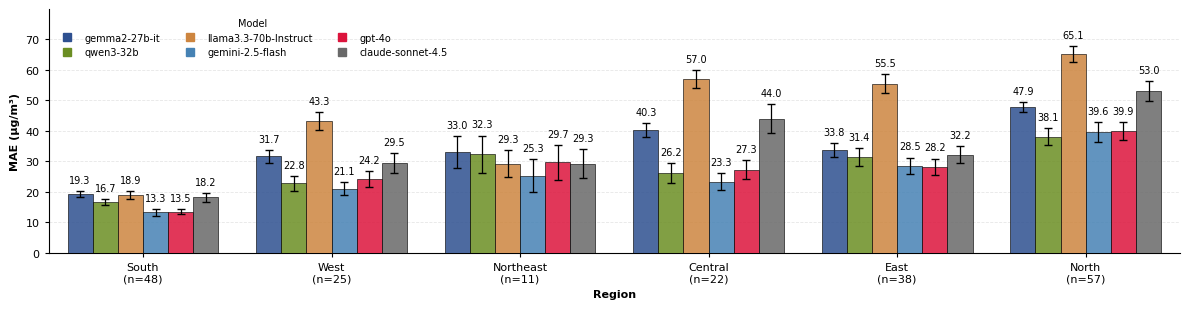

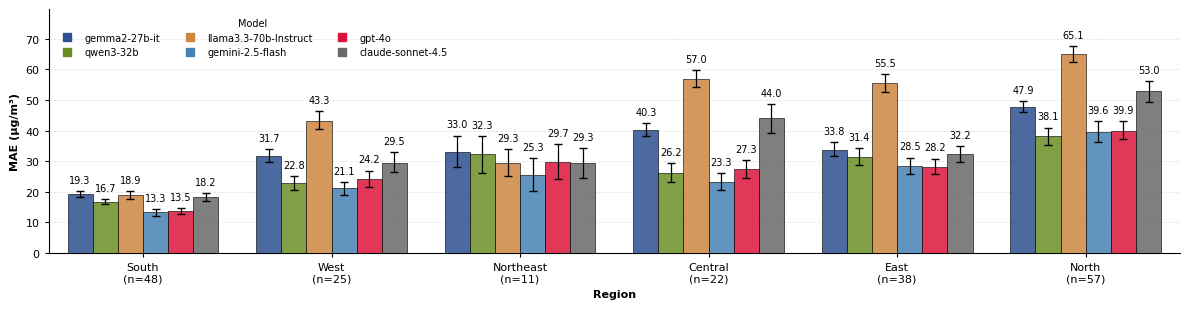

In [19]:
latexify(columns=2, fig_height=3.2, fig_width=12)

# SE bars
plot_region_mae_uncertainty(
    region_metrics_df,
    region_cities=region_cities,
    region_order=region_order,
    selected_models=selected_models,
    err_type="se",
    # save_path="region_mae_se.pdf",
)

# Parametric 95% CI bars
plot_region_mae_uncertainty(
    region_metrics_df,
    region_cities=region_cities,
    region_order=region_order,
    selected_models=selected_models,
    err_type="param_ci",
    # save_path="region_mae_param_ci.pdf",
)

# Bootstrap 95% CI bars
plot_region_mae_uncertainty(
    region_metrics_df,
    region_cities=region_cities,
    region_order=region_order,
    selected_models=selected_models,
    err_type="boot_ci",
    save_path="region_mae_boot_ci.pdf",
)


In [17]:
def plot_region_mae_mean_band(
    region_metrics_df,
    region_cities,
    region_order,
    selected_models,
    err_type="se",      # "se", "param_ci", "boot_ci"
    save_path=None,
):
    df = region_metrics_df.copy()

    # restrict to selected models
    df = df[df["Model"].isin(selected_models)]

    # enforce region & model order
    df["Region"] = pd.Categorical(df["Region"], categories=region_order, ordered=True)
    df["Model"] = pd.Categorical(df["Model"], categories=selected_models, ordered=True)
    df = df.sort_values(["Region", "Model"])

    x = np.arange(len(region_order))

    base_colors = ["#2E5090", "#6B8E23", "#CD853F", "#4682B4", "#DC143C", "#696969"]
    color_map = {
        model: base_colors[i % len(base_colors)]
        for i, model in enumerate(selected_models)
    }

    # helper to get band
    def get_band(sub):
        mean = sub["MAE"].to_numpy()

        if err_type == "se":
            err = sub["MAE_se"].to_numpy()
            low = mean - err
            high = mean + err
        elif err_type == "param_ci":
            low = sub["MAE_ci_low_param"].to_numpy()
            high = sub["MAE_ci_high_param"].to_numpy()
        elif err_type == "boot_ci":
            low = sub["MAE_ci_low_boot"].to_numpy()
            high = sub["MAE_ci_high_boot"].to_numpy()
        else:
            raise ValueError("err_type must be 'se', 'param_ci', or 'boot_ci'")
        return low, high

    # compute global y_max
    all_high = []
    for model in selected_models:
        sub = df[df["Model"] == model].copy()
        if sub.empty:
            continue
        sub = sub.set_index("Region").loc[region_order]
        _, high = get_band(sub)
        all_high.append(high)
    y_max = np.nanmax(np.concatenate(all_high))
    y_offset_label = y_max * 0.03

    fig, ax = plt.subplots(1, 1)

    for model in selected_models:
        sub = df[df["Model"] == model].copy()
        if sub.empty:
            continue
        sub = sub.set_index("Region").loc[region_order]

        y = sub["MAE"].to_numpy()
        low, high = get_band(sub)

        ax.plot(
            x,
            y,
            marker="o",
            linestyle="-",
            color=color_map[model],
            linewidth=1.2,
            label=model,
        )

        ax.fill_between(
            x,
            low,
            high,
            color=color_map[model],
            alpha=0.2,
        )

        # numeric labels on mean
        # for xp, yy in zip(x, y):
        #     ax.text(
        #         xp,
        #         yy + y_offset_label,
        #         f"{yy:.1f}",
        #         ha="center",
        #         va="bottom",
        #         fontsize=7,
        #     )

    region_labels = [f"{r}\n(n={region_cities.get(r, 0)})" for r in region_order]
    ax.set_xticks(x)
    ax.set_xticklabels(region_labels, fontsize=7)

    ax.set_xlabel("Region", fontsize=8, fontweight="bold")
    ax.set_ylabel("MAE (µg/m³)", fontsize=8, fontweight="bold")

    if np.isfinite(y_max):
        ax.set_ylim(0, float(y_max) * 1.18)

    ax.legend(
        fontsize=7,
        title="Model",
        title_fontsize=7,
        ncol=3,
        loc="upper left",
        frameon=False,
    )

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(0.8)
    ax.spines["bottom"].set_linewidth(0.8)
    ax.grid(axis="y", alpha=0.3, linestyle="--", linewidth=0.6)
    ax.set_axisbelow(True)
    ax.tick_params(labelsize=8, width=0.8, length=3)

    fig.tight_layout()

    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches="tight", format="pdf")

    plt.show()

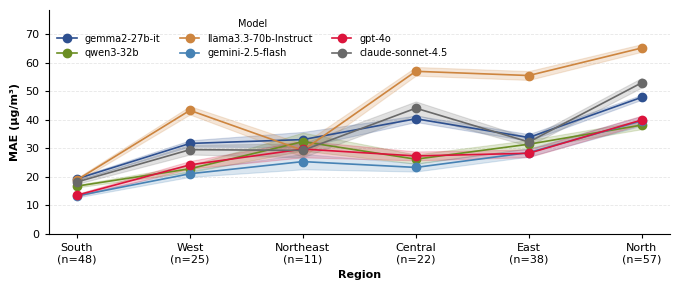

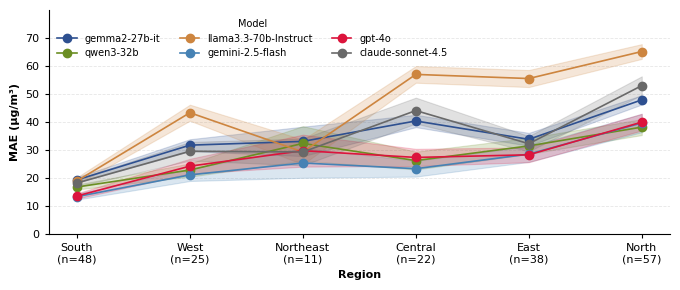

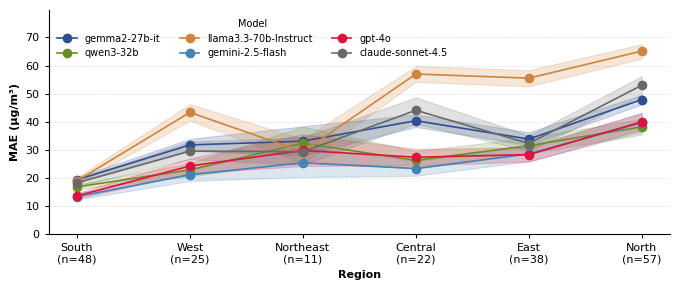

In [18]:
latexify(columns=2, fig_height=3)

# SE band
plot_region_mae_mean_band(
    region_metrics_df,
    region_cities=region_cities,
    region_order=region_order,
    selected_models=selected_models,
    err_type="se",
    # save_path="region_mae_mean_se.pdf",
)

# Parametric CI band
plot_region_mae_mean_band(
    region_metrics_df,
    region_cities=region_cities,
    region_order=region_order,
    selected_models=selected_models,
    err_type="param_ci",
    # save_path="region_mae_mean_param_ci.pdf",
)

# Bootstrap CI band
plot_region_mae_mean_band(
    region_metrics_df,
    region_cities=region_cities,
    region_order=region_order,
    selected_models=selected_models,
    err_type="boot_ci",
    # save_path="region_mae_mean_boot_ci.pdf",
)